In [1]:
# Author: Roi Yehoshua <roiyeho@gmail.com>
# License: MIT
# Date: March 2024

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

### 1. Data Loading and Preparation

In [2]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data[:, :2]  # Taking only the first two features
y = iris.target
class_labels = iris.target_names

# Filtering for setosa and versicolor flowers
X = X[(y == 0) | (y == 1)]
y = y[(y == 0) | (y == 1)]

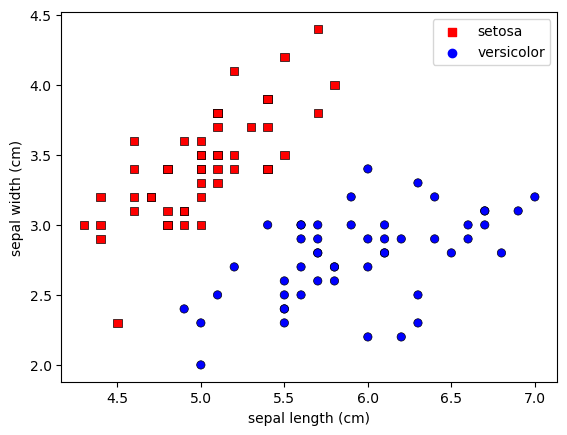

In [3]:
def plot_data(X, y):
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=class_labels[y], style=class_labels[y], 
                    palette=['r','b'], markers=('s','o'), edgecolor='k')
    plt.xlabel(iris.feature_names[0])
    plt.ylabel(iris.feature_names[1])
    plt.legend()    
    
plot_data(X, y)
plt.savefig('figures/iris_data.pdf')

In [4]:
n = X.shape[0]  # number of samples
X_b = np.hstack((np.ones((n, 1)), X))  # Append a column of ones for the bias

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_b, y, random_state=42)

### 2. Model Implementation

Logistic regression hypothesis: 

$$h_\textbf{w}(\textbf{x}) = p = \sigma(\textbf{w}^T\textbf{x})$$

$$\sigma(z) = \frac{1}{1+e^{-z}}$$

####  2.1 Sigmoid function

In [6]:
def sigmoid(z):    
    return 1 / (1 + np.exp(-z))

#### 2.2 Cost function and gradient

Cost function in logistic regression is:

$$J(\textbf{w}) = -\frac{1}{n}\sum_{i=1}^n\left[y_i \log p_i + (1-y_i)\log(1-p_i)\right]$$

Vectorized implementation:

$\textbf{p} = \sigma(X\textbf{w})$

$J(\textbf{w}) = -\frac{1}{n}\left(\textbf{y}^T \log(\textbf{p})+(\textbf{1}-\textbf{y})^T\log(\textbf{1}-\textbf{p})\right)$



The gradient of the cost is a vector of the same length as $\textbf{w}$ where $j^{th}$ element (for $j=0,1,...,m$) is defined as follows:

$$\frac{\partial J(\textbf{w})}{\partial w_j} = \frac{1}{n} \sum_{i=1}^n [(p_i - y_i) \cdot x_{ij}]$$

Vectorized:
$\nabla J(\textbf{w}) = \frac{1}{n} X^T (\textbf{p} - \textbf{y})$

In [7]:
def cost_function(X, y, w):
    """
    Compute the logistic regression cost and its gradient given features X, labels y, and parameters w.
    
    Args:
        X: Feature matrix for the dataset (with bias term included).
        y: Actual labels for the dataset.
        w: Parameters of the logistic regression model.
    
    Returns:
        cost, grad: A tuple containing the cost and the gradient.
    """
    n = len(y)  # Number of training examples
    p = sigmoid(np.dot(X, w))  # Predicted probabilities for class 1
    cost = -(1/n) * (y @ np.log(p) + (1 - y) @ np.log(1 - p))  # Logistic regression cost
    grad = (1/n) * X.T @ (p - y)  # Gradient of the cost

    return cost, grad

#### 2.3 Gradient descent

In [8]:
def optimize_model(X, y, alpha=0.1, max_iter=1000, tol=0.001):
    """
    Optimize logistic regression parameters using gradient descent.

    Args:
        X: The feature matrix for the training data, with a bias term included.
        y: The label vector for the training data.
        alpha: The learning rate.
        max_iter: The maximum number of iterations (epochs) to perform.
        tol: The tolerance for the cost reduction.

    Returns:
        w: The optimized parameters.
        cost_history: The costs from all the training iterations.
    """
    w = np.random.rand(X.shape[1])  # Initialize parameters randomly
    cost_history = []  # To store the cost at each iteration for analysis

    for i in range(max_iter):
        cost, grad = cost_function(X, y, w)  # Compute current cost and gradient        
        w = w - alpha * grad  # Update parameters
        cost_history.append(cost)  # Keep track of cost

        # Check for convergence
        if i > 0 and (cost_history[-2] - cost) < tol:            
            print(f'Convergence reached after {i} iterations.')
            return w, cost_history

    if i == max_iter - 1:
        print('Reached maximum iterations without convergence.')
        
    return w, cost_history

In [9]:
w_opt, cost_history = optimize_model(X_train, y_train)

print('Optimized weights:', w_opt)

Convergence reached after 159 iterations.
Optimized weights: [-0.05156288  1.20504233 -2.07024023]


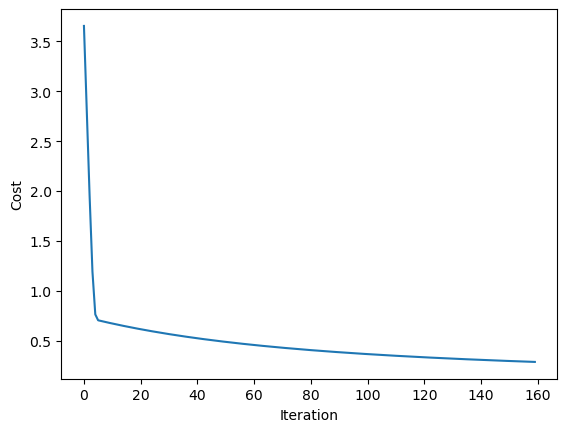

In [10]:
plt.plot(cost_history)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.savefig('figures/logistic_regression_learning_curve.pdf')

### 3. Using the Model for Predictions

In [11]:
def predict_prob(X, w_opt):
    """Calculate the probability that samples in X belong to the positive class."""
    p = sigmoid(X @ w_opt)
    return p

In [12]:
probability = predict_prob([[1, 6, 2]], w_opt)
print(probability)

[0.95427081]


In [13]:
probability = predict_prob([[1, 5.5, 3]], w_opt)
print(probability)

[0.59035889]


In [14]:
def predict(X, w_opt, threshold=0.5):
    """Classify samples in X as 0 or 1 based on a given probability threshold."""
    p = sigmoid(X @ w_opt)
    y_pred = (p >= threshold).astype(int)
    return y_pred

In [15]:
y_pred = predict([[1, 6, 2], [1, 5.5, 3]], w_opt)
y_pred

array([1, 1])

### 4. Model Evaluation

In [16]:
def evaluate_model(X, y, w_opt):
    """Calculate the accuracy of the logistic regression model on a given dataset."""
    y_pred = predict(X, w_opt)  # Predict class labels 
    accuracy = np.mean(y == y_pred)  # Compute proportion of correct predictions
    return accuracy

In [17]:
train_accuracy = evaluate_model(X_train, y_train, w_opt)
print(f'Train accuracy: {train_accuracy * 100:.3f}%')

test_accuracy = evaluate_model(X_test, y_test, w_opt)
print(f'Test accuracy: {test_accuracy * 100:.3f}%')

Train accuracy: 98.667%
Test accuracy: 100.000%


#### 5. Decision Boundary Visualization

In [18]:
def plot_decision_boundary(X, y, w_opt):
    """Plot the decision boundary between the classes."""
    plot_data(X, y)  # Utilize the previously defined function to plot data points
    
    # Determine the x-axis range of the current plot and compute the corresponding y values
    line_x = np.array(plt.gca().get_xlim())
    line_y = -1 / w_opt[2] * (w_opt[1] * line_x + w_opt[0])
    
    # Plot the decision boundary as a dashed line
    plt.plot(line_x, line_y, c='k', ls='--')

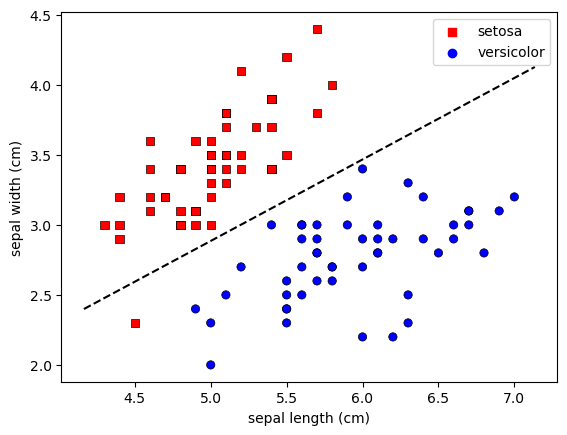

In [19]:
plot_decision_boundary(X, y, w_opt)
plt.savefig('figures/iris_logistic_decision_boundary.pdf')